In [2]:
%load_ext autoreload
%autoreload 2

In [81]:
from  process import *

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [28]:
train = pd.read_parquet(Path('../data/preprocessed/adv_train.pq'))
test = pd.read_parquet(Path('../data/preprocessed/adv_test.pq'))

In [82]:
train, test = set_age2(train, test)

In [83]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [84]:
train_n = train.drop(columns=DROP_FEATURES)
test_n = test.drop(columns=DROP_FEATURES)

In [54]:
class Tuner:
    """
    Search best hyperparameters for model.
    """

    def __init__(self, model, train_pool, val_pool, space, common_params={}, fit_params={}, int_params=[]):
        """
        Initialization.

        Parameters:
            model (Model) - ML model with sklearn API.
            train_pool (catboost.Pool, dim=(n,m)) - training data.
            val_pool (catboost.Pool, dim=(k,m)) - validation data.
            space (dict) - space for searching hyperparameters.
            common_params (dict) - common model's parameters.
            fit_params (dict) - parameters for method 'fit'.
            int_params (list) - list of integer parameters.
        """
        
        self.__model = model
        self.__train_pool = train_pool
        self.__val_pool = val_pool
        self.__space = space
        self.__common_params = common_params
        self.__fit_params = fit_params
        self.__int_params = int_params
    

    def __params2int(self, params):
        """
        Transform some hyperopt formats to integer.

        Parameters:
            params (dict) - model parameters.
        """
        
        for par in self.__int_params:
            params[par] = int(params[par])

        return params
    

    def __score(self, params):
        """
        Compute score over dictionary of parameters.

        Parameters:
            params (dict) - model parameters.
        """

        model = self.__model(**self.__common_params, **self.__params2int(params))\
                    .fit(self.__train_pool, 
                         eval_set=self.__val_pool, 
                         **self.__fit_params)
        
        y_pred = model.predict(self.__val_pool)
        loss = RMSE(self.__val_pool.get_label(), y_pred)
        
        return {"loss": loss, "status": STATUS_OK}
    

    def make_hyperopt(self, max_evals=50):
        """
        Make searching of hyperparameters.

        Parameters:
            max_evals (int) - max number of iterations for optimization.
        """

        self.trials = Trials()
        best = fmin(self.__score,
                    space=self.__space,
                    trials=self.trials,
                    algo=tpe.suggest,
                    max_evals=max_evals)
        self.best_parameters = self.__params2int(best)

In [66]:
SPACE = {
    "iterations": hp.quniform("iterations", 100, 1000, 50),
    "learning_rate": hp.uniform("learning_rate", 1e-1, 5e-1),
    "depth": hp.quniform("depth", 3, 16, 1),

    "min_child_samples": hp.quniform("min_child_samples", 10, 100, 10),

    "reg_lambda": hp.uniform("reg_lambda", 0, 10),

    
     "random_strength": hp.lognormal("random_strength", 1e-9, 1),
     "bagging_temperature": hp.quniform("bagging_temperature", 0, 10, 1),

#    "colsample_bylevel": hp.uniform("colsample_bylevel", 0, 1),
#   "subsample": hp.uniform("subsample", 0, 1)
}

COMMON_PARAMS = {
    "random_state": 42,
    "task_type": "GPU",
    "objective": "RMSE",
    "eval_metric": "RMSE",
    
    "od_type": "Iter",
    "od_wait": 20,
    "use_best_model": True
}

FIT_PARAMS = {
    "verbose": 0
}

INT_PARAMS = [
    "iterations", "depth", "min_child_samples", #"bagging_temperature"
]


MODEL = CatBoostRegressor

In [85]:
X_train, X_val = train_test_split(train_n.drop(columns=['id']), train_size=0.7, random_state=42)

In [86]:
train_pool = Pool(X_train.drop(columns=['salary']), np.log(X_train['salary']+1), cat_features=CAT_FEATURES)

In [87]:
val_pool = Pool(X_val.drop(columns=['salary']), np.log(X_val['salary']+1), cat_features=CAT_FEATURES)

In [68]:
tuner = Tuner(MODEL, train_pool, val_pool, SPACE, COMMON_PARAMS, FIT_PARAMS, INT_PARAMS)
tuner.make_hyperopt(max_evals=100)

100%|██████████████████████████████████████████████| 100/100 [31:32<00:00, 18.92s/trial, best loss: 0.9949401357485095]


In [69]:
tuner.best_parameters

{'bagging_temperature': 0.0,
 'depth': 10,
 'iterations': 100,
 'learning_rate': 0.26561363291515183,
 'min_child_samples': 70,
 'random_strength': 0.9115570762733113,
 'reg_lambda': 6.953237326616156}

In [88]:
est = CatBoostRegressor(**tuner.best_parameters)

In [89]:
est.fit(train_pool, eval_set=val_pool, verbose_eval=10)

0:	learn: 1.0717291	test: 1.0635907	best: 1.0635907 (0)	total: 183ms	remaining: 18.1s
10:	learn: 1.0052801	test: 1.0040091	best: 1.0040091 (10)	total: 1.78s	remaining: 14.4s
20:	learn: 0.9941658	test: 1.0007268	best: 1.0007268 (20)	total: 3.18s	remaining: 11.9s
30:	learn: 0.9897216	test: 0.9996604	best: 0.9996604 (30)	total: 4.25s	remaining: 9.45s
40:	learn: 0.9851071	test: 0.9990298	best: 0.9990275 (39)	total: 5.45s	remaining: 7.84s
50:	learn: 0.9826322	test: 0.9981866	best: 0.9981862 (47)	total: 6.49s	remaining: 6.24s
60:	learn: 0.9793411	test: 0.9976364	best: 0.9976106 (56)	total: 7.74s	remaining: 4.95s
70:	learn: 0.9758899	test: 0.9977830	best: 0.9976106 (56)	total: 9.34s	remaining: 3.81s
80:	learn: 0.9739798	test: 0.9978908	best: 0.9976106 (56)	total: 11s	remaining: 2.58s
90:	learn: 0.9721230	test: 0.9978438	best: 0.9976106 (56)	total: 12.8s	remaining: 1.26s
99:	learn: 0.9677208	test: 0.9976084	best: 0.9976084 (99)	total: 14.3s	remaining: 0us

bestTest = 0.9976083712
bestIteration

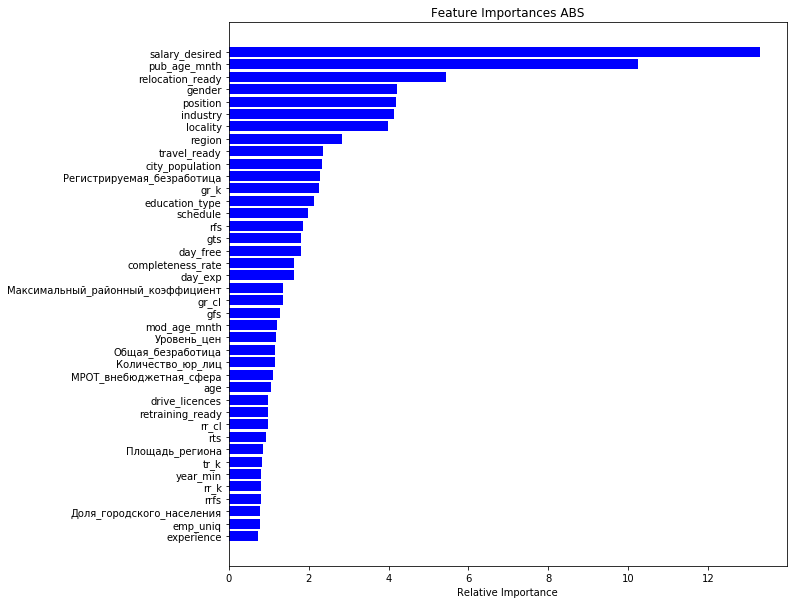

In [90]:
importance = sorted(zip(X_train.drop(columns=['salary']).columns, est.feature_importances_), key=lambda x: x[1], reverse=True)
imp = list(reversed(importance[:40]))
plt.figure(figsize=(10,10))
plt.title('Feature Importances ABS')
plt.barh(range(len(imp)), [x[1] for x in imp], color='b', align='center')
plt.yticks(range(len(imp)), [x[0] for x in imp])
plt.xlabel('Relative Importance')
plt.show()

In [91]:
np.sqrt(mean_squared_log_error(X_val['salary'], np.exp(est.predict(val_pool))-1))

0.99760837067426

0.997859426677459

In [92]:
np.sqrt(mean_squared_log_error(X_train['salary'], np.exp(est.predict(train_pool))-1))

0.966665672020638

0.9645155233472713

In [93]:
est.fit(train_n.drop(columns=['id', 'salary']), 
        np.log(train_n['salary']+1), 
        verbose_eval=10,
       cat_features=CAT_FEATURES)

0:	learn: 1.0675988	total: 266ms	remaining: 26.3s
10:	learn: 1.0041677	total: 2.13s	remaining: 17.3s
20:	learn: 0.9958106	total: 3.83s	remaining: 14.4s
30:	learn: 0.9904711	total: 5.34s	remaining: 11.9s
40:	learn: 0.9848583	total: 6.96s	remaining: 10s
50:	learn: 0.9813136	total: 8.87s	remaining: 8.52s
60:	learn: 0.9791017	total: 10.7s	remaining: 6.84s
70:	learn: 0.9772326	total: 12.6s	remaining: 5.15s
80:	learn: 0.9747880	total: 14.7s	remaining: 3.44s
90:	learn: 0.9721687	total: 16.7s	remaining: 1.66s
99:	learn: 0.9711939	total: 18.6s	remaining: 0us


In [94]:
np.sqrt(mean_squared_log_error(train_n['salary'], 
                               np.exp(est.predict(train_n.drop(columns=['id', 'salary'])))-1))

0.9678006684793359


0.9679435998332367

In [95]:
predict=np.exp(est.predict(test_n.drop(columns=['id'])))-1

In [96]:
sub = test_n[['id']].copy()

In [97]:
sub['salary'] = predict

In [98]:
sub.to_csv(Path('../submissions/cb_4_ho_plus_sub.csv'), index=False, sep=",")